In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import tensorflow_probability as tfp

### cifar experiments

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32) / 255.
    # image = tf.reshape(image, (-1,))
    return image, label

def make_ds(ds):
  ds = ds.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.cache().repeat()
  ds = ds.shuffle(int(1e5))
  ds = ds.batch(128)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

ds_train, ds_test = out = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
ds_train = make_ds(ds_train)
iter_train = iter(ds_train)
ds_test = make_ds(ds_test)
iter_test = iter(ds_test)

results = {}
corruption_type_list = ['brightness_1', 'elastic_5', 'fog_5', 'frost_5', 'frosted_glass_blur_5']

history_vec = []
for L in [0.0, 1.0]:
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

  @tf.function
  def loss_fn(X, Y):
    Y_hat = model(X)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true=Y, y_pred=Y_hat)
    accuracy = tf.reduce_mean(tf.cast(tf.argmax(Y_hat, axis=1) == Y, tf.float32))

    ### Original version
    version = 'original'
    step_size = 0.1
    if version == 'original':
      for _ in range(1 if L else 0):
        with tf.GradientTape() as tape:
          tape.watch(X)
          Y_hat = model(X)
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true=Y, y_pred=Y_hat)
        grads = tape.gradient(loss, X)
        grads_norm = tf.norm(tf.reshape(grads, (128, -1)), axis=1)
        grads = -step_size * grads / grads_norm[:, None, None, None]
        X = tf.clip_by_value(X + grads, 0.0, 1.0)

      Y_hat = model(X)  
      loss2 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=tf.ones_like(Y_hat) / 10.0, y_pred=Y_hat)
      return loss + L * loss2, loss2, accuracy
    elif version == 'entropy':
      with tf.GradientTape() as tape:
        tape.watch(X)
        Y_hat = model(X)
        entropy = -1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1)
      grads = tape.gradient(entropy, X)
      grads_norm = tf.norm(tf.reshape(grads, (128, -1)), axis=1)
      grads = -step_size * grads / grads_norm[:, None, None, None]      
      X = tf.clip_by_value(X + grads, 0.0, 1.0)

      Y_hat = model(X)
      entropy = -1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1)
      loss2 = -1.0 * tf.reduce_mean(entropy)
      return loss + L * loss2, loss2, accuracy
    else:
      raise ValueError

  @tf.function
  def step_fn(X_train, Y_train):
    with tf.GradientTape() as tape:
      loss, loss2, accuracy = loss_fn(X_train, Y_train)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, loss2, accuracy

  history = []
  for t in tqdm.trange(10000):
    X_train, Y_train = next(iter_train)
    train_loss, train_loss2, train_acc = step_fn(X_train, Y_train)
    if t % 10 == 0:
      X_test, Y_test = next(iter_test)
      test_loss, test_loss2, test_acc = loss_fn(X_test, Y_test)
    history.append((train_loss.numpy(), test_loss.numpy(), train_acc.numpy(), test_acc.numpy(),
                    train_loss2.numpy(), test_loss2.numpy()))
    if t % 100 == 0:
      print(train_acc.numpy(), test_acc.numpy(), train_loss2.numpy())
      print()

  history = np.array(history)
  history_vec.append(history)
  continue
  plt.figure(figsize=(12, 6))
  plt.title('L = %s' % L)
  plt.subplot(221)
  plt.title('Loss')
  plt.plot(history[:, 0], label='train')
  plt.plot(history[:, 1], label='val')
  plt.grid()
  plt.legend()
  
  plt.subplot(222)
  plt.title('Accuracy')
  plt.plot(history[:, 2], label='train')
  plt.plot(history[:, 3], label='val')
  plt.grid()
  plt.legend()

  plt.subplot(223)
  plt.title('Loss2')
  plt.plot(history[:, 4], label='train')
  plt.plot(history[:, 5], label='val')
  plt.grid()
  plt.legend()
  plt.show()

  @tf.function
  def eval_ood_helper(X_real, X_fake):
    Y_hat_real = model(X_real)
    entropy_real = -1.0 * tf.reduce_mean(Y_hat_real * tf.math.log(Y_hat_real), axis=1)
    Y_hat_fake = model(X_fake)
    entropy_fake = -1.0 * tf.reduce_mean(Y_hat_fake * tf.math.log(Y_hat_fake), axis=1)
    return tf.concat([entropy_real, entropy_fake], axis=0)

  def eval_ood(X_real, X_fake):
    logits = eval_ood_helper(X_real, X_fake).numpy()
    labels = np.concatenate([np.zeros(128), np.ones(128)])
    auc = roc_auc_score(labels, logits)
    return auc
  
  @tf.function
  def get_metrics(X, Y):
    logits = tf.math.log(model(X))
    brier = tf.reduce_mean(tfp.stats.brier_score(labels=Y, logits=logits))
    ece = tfp.stats.expected_calibration_error(num_bins=20, logits=logits, labels_true=Y)
    nll = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true=Y, y_pred=logits)
    return brier, ece, nll

  for corruption_type in corruption_type_list:
    print(corruption_type)
    (ds_corrupted,) = tfds.load(
        'cifar10_corrupted/%s' % corruption_type,
        split=['test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=False,
    )
    ds_corrupted = make_ds(ds_corrupted)
    iter_corrupted = iter(ds_corrupted)

    acc_vec = []
    auc_vec = []
    brier_vec = []
    ece_vec = []
    nll_vec = []
    for _ in tqdm.trange(100):
      X_test, Y_test = next(iter_test)
      _, _, test_acc = loss_fn(X_test, Y_test)
      X_corrupted, Y_corrupted = next(iter_corrupted)
      test_auc = eval_ood(X_test, X_corrupted)
      brier, ece, nll = get_metrics(X_corrupted, Y_corrupted)

      acc_vec.append(test_acc.numpy())
      auc_vec.append(test_auc)
      brier_vec.append(brier.numpy())
      ece_vec.append(ece.numpy())
      nll_vec.append(nll.numpy())
    results[(corruption_type, L)] = (np.mean(acc_vec), np.mean(auc_vec), np.mean(brier_vec), np.mean(ece_vec), np.mean(nll_vec))

  1%|          | 91/10000 [00:09<08:09, 20.26it/s]

0.0859375 0.125 2.3122709

0.3359375

  2%|▏         | 181/10000 [00:09<02:29, 65.83it/s]

 0.3125 2.6844554

0.4140625

  3%|▎         | 300/10000 [00:09<00:58, 166.66it/s]

 0.375 3.0478287

0.515625

  4%|▍         | 391/10000 [00:10<00:41, 229.53it/s]

 0.484375 3.2809196

0.4140625

  5%|▍         | 481/10000 [00:10<00:35, 269.59it/s]

 0.5390625 3.4055882

0.484375

  6%|▌         | 572/10000 [00:10<00:32, 286.90it/s]

 0.4765625 3.6855962

0.5

  7%|▋         | 693/10000 [00:11<00:31, 296.50it/s]

 0.484375 3.6871848

0.5625

  8%|▊         | 786/10000 [00:11<00:31, 296.81it/s]

 0.59375 3.8707004

0.5625

  9%|▉         | 878/10000 [00:11<00:30, 301.11it/s]

 0.484375 4.002697

0.484375

 10%|▉         | 971/10000 [00:12<00:29, 301.93it/s]

 0.53125 3.8999069

0.546875

 11%|█         | 1095/10000 [00:12<00:29, 300.29it/s]

 0.4921875 3.9819229

0.4609375

 12%|█▏        | 1186/10000 [00:12<00:29, 295.34it/s]

 0.5859375 3.9088936

0.53125

 13%|█▎        | 1279/10000 [00:13<00:28, 300.90it/s]

 0.625 4.081667

0.578125

 14%|█▎        | 1371/10000 [00:13<00:28, 298.22it/s]

 0.5859375 4.225831

0.546875

 15%|█▍        | 1494/10000 [00:13<00:28, 299.83it/s]

 0.5625 4.167826

0.4765625

 16%|█▌        | 1587/10000 [00:14<00:27, 301.36it/s]

 0.515625 3.9589393

0.609375

 17%|█▋        | 1680/10000 [00:14<00:27, 301.21it/s]

 0.5625 4.0891876

0.546875

 18%|█▊        | 1773/10000 [00:14<00:27, 301.11it/s]

 0.6015625 4.0784674

0.609375

 19%|█▉        | 1897/10000 [00:15<00:26, 300.66it/s]

 0.5546875 4.304881

0.578125

 20%|█▉        | 1990/10000 [00:15<00:26, 301.85it/s]

 0.5390625 4.4094896

0.65625

 21%|██        | 2083/10000 [00:15<00:26, 303.48it/s]

 0.578125 4.217665

0.5859375

 22%|██▏       | 2176/10000 [00:16<00:25, 303.23it/s]

 0.578125 4.2940073

0.5546875

 23%|██▎       | 2300/10000 [00:16<00:25, 302.23it/s]

 0.5625 4.1368613

0.671875

 24%|██▍       | 2393/10000 [00:16<00:25, 302.00it/s]

 0.5703125 4.3124976

0.6484375

 25%|██▍       | 2486/10000 [00:17<00:24, 300.67it/s]

 0.546875 4.6488543

0.671875

 26%|██▌       | 2579/10000 [00:17<00:24, 302.41it/s]

 0.625 4.605804

0.6171875

 27%|██▋       | 2672/10000 [00:17<00:24, 298.19it/s]

 0.5703125 4.3466725

0.59375

 28%|██▊       | 2797/10000 [00:18<00:23, 304.50it/s]

 0.625 4.5826397

0.546875

 29%|██▉       | 2891/10000 [00:18<00:23, 302.14it/s]

 0.6015625 4.330715

0.6484375

 30%|██▉       | 2984/10000 [00:18<00:23, 302.50it/s]

 0.6484375 4.4590936

0.59375

 31%|███       | 3077/10000 [00:19<00:22, 305.20it/s]

 0.65625 4.5549307

0.65625

 32%|███▏      | 3171/10000 [00:19<00:22, 305.85it/s]

 0.625 4.4604855

0.640625

 33%|███▎      | 3295/10000 [00:19<00:22, 304.36it/s]

 0.5546875 4.454208

0.5859375

 34%|███▍      | 3388/10000 [00:20<00:21, 305.99it/s]

 0.6015625 4.5972023

0.625

 35%|███▍      | 3481/10000 [00:20<00:21, 300.90it/s]

 0.6640625 4.77362

0.6640625

 36%|███▌      | 3575/10000 [00:20<00:21, 304.12it/s]

 0.6484375 4.8240743

0.7421875

 37%|███▋      | 3699/10000 [00:21<00:20, 305.01it/s]

 0.609375 4.6942925

0.6484375

 38%|███▊      | 3792/10000 [00:21<00:20, 304.33it/s]

 0.6328125 4.3708134

0.6328125

 39%|███▉      | 3885/10000 [00:21<00:20, 302.42it/s]

 0.5546875 4.9960823

0.703125

 40%|███▉      | 3978/10000 [00:22<00:19, 301.73it/s]

 0.671875 4.782033

0.71875

 41%|████      | 4071/10000 [00:22<00:19, 305.34it/s]

 0.6640625 4.792134

0.703125

 42%|████▏     | 4196/10000 [00:22<00:18, 307.84it/s]

 0.6328125 5.1748376

0.671875

 43%|████▎     | 4290/10000 [00:23<00:18, 309.16it/s]

 0.6015625 4.950449

0.59375

 44%|████▍     | 4383/10000 [00:23<00:18, 304.42it/s]

 0.671875 4.6426396

0.6484375

 45%|████▍     | 4477/10000 [00:23<00:18, 306.20it/s]

 0.6015625 4.9322968

0.640625

 46%|████▌     | 4570/10000 [00:24<00:17, 305.13it/s]

 0.5625 5.1231894

0.7265625

 47%|████▋     | 4694/10000 [00:24<00:17, 303.57it/s]

 0.703125 5.0417805

0.6015625

 48%|████▊     | 4787/10000 [00:24<00:17, 304.17it/s]

 0.6953125 4.9553404

0.6171875

 49%|████▉     | 4880/10000 [00:25<00:17, 300.26it/s]

 0.671875 4.9842863

0.6953125

 50%|████▉     | 4973/10000 [00:25<00:16, 303.52it/s]

 0.609375 5.267575

0.734375

 51%|█████     | 5098/10000 [00:25<00:16, 304.55it/s]

 0.6328125 4.969394

0.7265625

 52%|█████▏    | 5191/10000 [00:26<00:16, 299.77it/s]

 0.6484375 4.8376446

0.6640625

 53%|█████▎    | 5284/10000 [00:26<00:15, 302.04it/s]

 0.6953125 5.136471

0.6328125

 54%|█████▍    | 5378/10000 [00:26<00:15, 305.75it/s]

 0.6328125 5.162395

0.6484375

 55%|█████▍    | 5472/10000 [00:26<00:14, 306.41it/s]

 0.6796875 5.1010284

0.6875

 56%|█████▌    | 5597/10000 [00:27<00:14, 307.03it/s]

 0.6015625 5.22267

0.703125

 57%|█████▋    | 5690/10000 [00:27<00:14, 302.74it/s]

 0.7265625 5.183512

0.703125

 58%|█████▊    | 5783/10000 [00:28<00:14, 301.15it/s]

 0.6953125 5.2767735

0.65625

 59%|█████▉    | 5876/10000 [00:28<00:13, 304.54it/s]

 0.6875 5.0709953

0.671875

 60%|██████    | 6000/10000 [00:28<00:13, 306.80it/s]

 0.71875 5.025162

0.75

 61%|██████    | 6093/10000 [00:29<00:12, 304.87it/s]

 0.6796875 5.2679834

0.7578125

 62%|██████▏   | 6188/10000 [00:29<00:12, 308.54it/s]

 0.59375 5.3404093

0.6640625

 63%|██████▎   | 6281/10000 [00:29<00:12, 302.31it/s]

 0.6875 5.0012836

0.6875

 64%|██████▎   | 6374/10000 [00:29<00:12, 300.03it/s]

 0.6640625 5.2139993

0.703125

 65%|██████▍   | 6498/10000 [00:30<00:11, 302.12it/s]

 0.6953125 5.168806

0.625

 66%|██████▌   | 6591/10000 [00:30<00:11, 300.83it/s]

 0.71875 5.255583

0.671875

 67%|██████▋   | 6685/10000 [00:30<00:10, 304.31it/s]

 0.75 5.479656

0.7109375

 68%|██████▊   | 6779/10000 [00:31<00:10, 306.38it/s]

 0.6796875 5.325577

0.578125

 69%|██████▊   | 6873/10000 [00:31<00:10, 306.37it/s]

 0.671875 5.2734585

0.640625

 70%|███████   | 7000/10000 [00:31<00:09, 312.48it/s]

 0.6640625 5.1486464

0.7109375

 71%|███████   | 7096/10000 [00:32<00:09, 313.78it/s]

 0.6796875 5.2122173

0.65625

 72%|███████▏  | 7192/10000 [00:32<00:08, 313.82it/s]

 0.65625 5.376298

0.7421875

 73%|███████▎  | 7287/10000 [00:32<00:08, 312.13it/s]

 0.65625 5.1971025

0.671875

 74%|███████▍  | 7382/10000 [00:33<00:08, 308.51it/s]

 0.6875 5.46819

0.75

 75%|███████▍  | 7476/10000 [00:33<00:08, 308.33it/s]

 0.71875 5.3531833

0.703125

 76%|███████▌  | 7571/10000 [00:33<00:07, 308.73it/s]

 0.7421875 5.4831734

0.7265625

 77%|███████▋  | 7669/10000 [00:34<00:07, 317.70it/s]

 0.671875 5.1559286

0.7890625

 78%|███████▊  | 7800/10000 [00:34<00:06, 320.13it/s]

 0.6875 5.546059

0.7421875

 79%|███████▉  | 7897/10000 [00:34<00:06, 312.26it/s]

 0.6875 5.670807

0.7421875

 80%|███████▉  | 7993/10000 [00:35<00:06, 313.60it/s]

 0.671875 5.6290607

0.75

 81%|████████  | 8090/10000 [00:35<00:06, 315.26it/s]

 0.765625 5.7726903

0.7265625

 82%|████████▏ | 8186/10000 [00:35<00:05, 312.34it/s]

 0.6875 5.84216

0.8046875

 83%|████████▎ | 8282/10000 [00:36<00:05, 312.27it/s]

 0.6953125 5.8083305

0.75

 84%|████████▍ | 8379/10000 [00:36<00:05, 316.16it/s]

 0.6875 5.759961

0.6640625

 85%|████████▍ | 8475/10000 [00:36<00:04, 312.72it/s]

 0.71875 5.744277

0.765625

 86%|████████▌ | 8571/10000 [00:37<00:04, 310.85it/s]

 0.75 5.666951

0.765625

 87%|████████▋ | 8699/10000 [00:37<00:04, 310.44it/s]

 0.6953125 5.7892394

0.734375

 88%|████████▊ | 8794/10000 [00:37<00:03, 309.42it/s]

 0.75 5.5551486

0.7890625

 89%|████████▉ | 8887/10000 [00:38<00:03, 307.58it/s]

 0.6484375 6.21512

0.78125

 90%|████████▉ | 8981/10000 [00:38<00:03, 306.92it/s]

 0.6640625 5.770459

0.703125

 91%|█████████ | 9078/10000 [00:38<00:02, 309.90it/s]

 0.671875 5.5537734

0.7734375

 92%|█████████▏| 9172/10000 [00:38<00:02, 308.70it/s]

 0.6328125 5.9998493

0.78125

 93%|█████████▎| 9300/10000 [00:39<00:02, 314.31it/s]

 0.7265625 5.6886683

0.75

 94%|█████████▍| 9396/10000 [00:39<00:01, 313.04it/s]

 0.6171875 6.020164

0.7265625

 95%|█████████▍| 9492/10000 [00:39<00:01, 315.17it/s]

 0.6953125 6.047456

0.7421875

 96%|█████████▌| 9589/10000 [00:40<00:01, 314.38it/s]

 0.703125 5.8485374

0.7421875

 97%|█████████▋| 9685/10000 [00:40<00:01, 313.80it/s]

 0.6328125 6.079657

0.7421875

 98%|█████████▊| 9781/10000 [00:40<00:00, 312.54it/s]

 0.6640625 5.8271403

0.7734375

 99%|█████████▉| 9876/10000 [00:41<00:00, 309.14it/s]

 0.7734375 5.693945

0.765625

  0%|          | 0/10000 [00:00<?, ?it/s]

 0.7265625 6.0123363

0.1015625

  1%|          | 96/10000 [00:01<01:13, 134.96it/s]

 0.1328125 2.3049626

0.34375

  2%|▏         | 191/10000 [00:01<00:56, 174.58it/s]

 0.3828125 2.3942308

0.3984375

  3%|▎         | 286/10000 [00:02<00:53, 181.62it/s]

 0.3984375 2.4466925

0.4921875

  4%|▍         | 400/10000 [00:02<00:52, 184.35it/s]

 0.359375 2.4637537

0.453125

  5%|▍         | 495/10000 [00:03<00:51, 185.96it/s]

 0.5234375 2.493345

0.515625

  6%|▌         | 590/10000 [00:03<00:51, 184.09it/s]

 0.546875 2.5203998

0.5234375

  7%|▋         | 685/10000 [00:04<00:50, 185.07it/s]

 0.5625 2.4941194

0.53125

  8%|▊         | 799/10000 [00:04<00:49, 185.08it/s]

 0.5 2.5263479

0.5625

  9%|▉         | 894/10000 [00:05<00:49, 184.53it/s]

 0.546875 2.5045671

0.53125

 10%|▉         | 989/10000 [00:05<00:48, 185.06it/s]

 0.609375 2.5021017

0.5546875

 11%|█         | 1084/10000 [00:06<00:48, 183.77it/s]

 0.6015625 2.553017

0.546875

 12%|█▏        | 1198/10000 [00:07<00:47, 185.54it/s]

 0.578125 2.5173168

0.46875

 13%|█▎        | 1293/10000 [00:07<00:47, 184.61it/s]

 0.6484375 2.515221

0.546875

 14%|█▍        | 1390/10000 [00:08<00:45, 187.21it/s]

 0.578125 2.5542374

0.53125

 15%|█▍        | 1485/10000 [00:08<00:45, 186.15it/s]

 0.671875 2.5043945

0.6640625

 16%|█▌        | 1600/10000 [00:09<00:44, 186.92it/s]

 0.546875 2.5695972

0.609375

 17%|█▋        | 1695/10000 [00:09<00:44, 186.50it/s]

 0.6328125 2.555799

0.5859375

 18%|█▊        | 1790/10000 [00:10<00:44, 186.38it/s]

 0.59375 2.541041

0.5390625

 19%|█▉        | 1885/10000 [00:10<00:44, 183.52it/s]

 0.5234375 2.5321836

0.53125

 20%|█▉        | 1999/10000 [00:11<00:43, 183.63it/s]

 0.6640625 2.5599027

0.5859375

 21%|██        | 2094/10000 [00:11<00:43, 183.61it/s]

 0.6640625 2.547139

0.6015625

 22%|██▏       | 2190/10000 [00:12<00:42, 185.36it/s]

 0.625 2.5539646

0.6015625

 23%|██▎       | 2285/10000 [00:12<00:41, 185.47it/s]

 0.6328125 2.5603197

0.578125

 24%|██▍       | 2399/10000 [00:13<00:40, 186.02it/s]

 0.6484375 2.5419126

0.6796875

 25%|██▍       | 2494/10000 [00:14<00:41, 181.77it/s]

 0.6328125 2.5461419

0.6015625

 26%|██▌       | 2590/10000 [00:14<00:39, 185.45it/s]

 0.671875 2.5520883

0.6484375

 27%|██▋       | 2685/10000 [00:15<00:39, 185.95it/s]

 0.6875 2.5567517

0.6796875

 28%|██▊       | 2799/10000 [00:15<00:39, 183.73it/s]

 0.65625 2.5742927

0.6171875

 29%|██▉       | 2894/10000 [00:16<00:38, 185.40it/s]

 0.6640625 2.5315804

0.703125

 30%|██▉       | 2989/10000 [00:16<00:37, 185.35it/s]

 0.609375 2.5809188

0.7890625

 31%|███       | 3084/10000 [00:17<00:37, 185.15it/s]

 0.6796875 2.6058512

0.6953125

 32%|███▏      | 3199/10000 [00:17<00:36, 187.18it/s]

 0.625 2.5867894

0.6953125

 33%|███▎      | 3294/10000 [00:18<00:36, 186.03it/s]

 0.6875 2.586607

0.6484375

 34%|███▍      | 3389/10000 [00:18<00:35, 185.65it/s]

 0.6484375 2.5899978

0.703125

 35%|███▍      | 3484/10000 [00:19<00:35, 184.98it/s]

 0.7265625 2.5847323

0.6484375

 36%|███▌      | 3599/10000 [00:20<00:34, 185.42it/s]

 0.6484375 2.5812087

0.6953125

 37%|███▋      | 3694/10000 [00:20<00:33, 186.14it/s]

 0.71875 2.6295266

0.703125

 38%|███▊      | 3790/10000 [00:21<00:33, 187.03it/s]

 0.6640625 2.5659714

0.640625

 39%|███▉      | 3885/10000 [00:21<00:32, 187.66it/s]

 0.6484375 2.580329

0.65625

 40%|███▉      | 3981/10000 [00:22<00:32, 187.70it/s]

 0.6875 2.5639353

0.6875

 41%|████      | 4096/10000 [00:22<00:31, 187.27it/s]

 0.6328125 2.5980299

0.6875

 42%|████▏     | 4191/10000 [00:23<00:31, 187.16it/s]

 0.6796875 2.6099415

0.7265625

 43%|████▎     | 4286/10000 [00:23<00:30, 185.15it/s]

 0.7265625 2.632594

0.7421875

 44%|████▍     | 4400/10000 [00:24<00:29, 187.22it/s]

 0.6328125 2.606586

0.7265625

 45%|████▍     | 4495/10000 [00:24<00:29, 185.67it/s]

 0.6484375 2.5984206

0.703125

 46%|████▌     | 4590/10000 [00:25<00:29, 186.47it/s]

 0.6875 2.5954902

0.6953125

 47%|████▋     | 4685/10000 [00:25<00:28, 186.08it/s]

 0.7109375 2.591138

0.7109375

 48%|████▊     | 4800/10000 [00:26<00:27, 187.49it/s]

 0.65625 2.6062467

0.7578125

 49%|████▉     | 4895/10000 [00:27<00:27, 186.08it/s]

 0.7109375 2.6170812

0.6953125

 50%|████▉     | 4991/10000 [00:27<00:26, 186.13it/s]

 0.703125 2.5823407

0.734375

 51%|█████     | 5086/10000 [00:28<00:26, 186.04it/s]

 0.7265625 2.6091914

0.796875

 52%|█████▏    | 5181/10000 [00:28<00:25, 187.04it/s]

 0.7265625 2.6541948

0.8046875

 53%|█████▎    | 5296/10000 [00:29<00:25, 187.16it/s]

 0.6015625 2.6056077

0.7578125

 54%|█████▍    | 5391/10000 [00:29<00:24, 184.43it/s]

 0.703125 2.623515

0.703125

 55%|█████▍    | 5486/10000 [00:30<00:24, 184.78it/s]

 0.6328125 2.6214027

0.6875

 56%|█████▌    | 5600/10000 [00:30<00:23, 183.47it/s]

 0.6953125 2.5999222

0.7578125

 57%|█████▋    | 5695/10000 [00:31<00:23, 182.74it/s]

 0.65625 2.6239066

0.71875

 58%|█████▊    | 5790/10000 [00:31<00:22, 184.73it/s]

 0.75 2.6135764

0.7734375

 59%|█████▉    | 5885/10000 [00:32<00:22, 184.42it/s]

 0.6796875 2.61791

0.71875

 60%|█████▉    | 5999/10000 [00:33<00:21, 184.99it/s]

 0.703125 2.6279821

0.7578125

 61%|██████    | 6094/10000 [00:33<00:21, 184.32it/s]

 0.7109375 2.6146092

0.796875

 62%|██████▏   | 6189/10000 [00:34<00:20, 184.93it/s]

 0.6328125 2.6284533

0.796875

 63%|██████▎   | 6284/10000 [00:34<00:20, 185.18it/s]

 0.6953125 2.6351714

0.6953125

 64%|██████▍   | 6400/10000 [00:35<00:19, 186.53it/s]

 0.6640625 2.6079092

0.7734375

 65%|██████▍   | 6495/10000 [00:35<00:18, 185.09it/s]

 0.6953125 2.6403484

0.6484375

 66%|██████▌   | 6590/10000 [00:36<00:18, 184.22it/s]

 0.7109375 2.616814

0.703125

 67%|██████▋   | 6685/10000 [00:36<00:18, 182.65it/s]

 0.7109375 2.6164246

0.7421875

 68%|██████▊   | 6799/10000 [00:37<00:17, 184.63it/s]

 0.6953125 2.6143913

0.7265625

 69%|██████▉   | 6894/10000 [00:37<00:16, 186.07it/s]

 0.7109375 2.6380005

0.7265625

 70%|██████▉   | 6989/10000 [00:38<00:16, 185.91it/s]

 0.6640625 2.6390316

0.75

 71%|███████   | 7084/10000 [00:38<00:15, 186.22it/s]

 0.6171875 2.6346364

0.7578125

 72%|███████▏  | 7181/10000 [00:39<00:14, 188.90it/s]

 0.65625 2.6400504

0.7734375

 73%|███████▎  | 7299/10000 [00:40<00:14, 188.01it/s]

 0.6640625 2.5950546

0.7265625

 74%|███████▍  | 7394/10000 [00:40<00:14, 183.47it/s]

 0.78125 2.6207955

0.7578125

 75%|███████▍  | 7491/10000 [00:41<00:13, 187.25it/s]

 0.671875 2.6365452

0.8203125

 76%|███████▌  | 7586/10000 [00:41<00:12, 188.10it/s]

 0.6796875 2.658443

0.8046875

 77%|███████▋  | 7700/10000 [00:42<00:12, 188.15it/s]

 0.640625 2.6418016

0.765625

 78%|███████▊  | 7795/10000 [00:42<00:11, 187.46it/s]

 0.734375 2.6259549

0.765625

 79%|███████▉  | 7891/10000 [00:43<00:11, 188.36it/s]

 0.671875 2.640584

0.75

 80%|███████▉  | 7987/10000 [00:43<00:10, 187.33it/s]

 0.6484375 2.6065001

0.8125

 81%|████████  | 8084/10000 [00:44<00:10, 189.35it/s]

 0.6875 2.6370454

0.8203125

 82%|████████▏ | 8181/10000 [00:44<00:09, 188.95it/s]

 0.7734375 2.6482778

0.796875

 83%|████████▎ | 8296/10000 [00:45<00:09, 187.94it/s]

 0.7109375 2.641883

0.78125

 84%|████████▍ | 8391/10000 [00:45<00:08, 185.33it/s]

 0.7734375 2.631827

0.796875

 85%|████████▍ | 8486/10000 [00:46<00:08, 185.98it/s]

 0.65625 2.632411

0.78125

 86%|████████▌ | 8581/10000 [00:46<00:07, 186.09it/s]

 0.75 2.645259

0.7109375

 87%|████████▋ | 8681/10000 [00:47<00:06, 188.65it/s]

 0.671875 2.6450534

0.78125

 88%|████████▊ | 8796/10000 [00:48<00:06, 183.47it/s]

 0.734375 2.6308315

0.8359375

 89%|████████▉ | 8891/10000 [00:48<00:06, 184.46it/s]

 0.671875 2.6432648

0.8203125

 90%|████████▉ | 8986/10000 [00:49<00:05, 183.65it/s]

 0.7265625 2.6744323

0.7421875

 91%|█████████ | 9081/10000 [00:49<00:04, 184.28it/s]

 0.71875 2.6626234

0.796875

 92%|█████████▏| 9196/10000 [00:50<00:04, 186.73it/s]

 0.78125 2.6820612

0.765625

 93%|█████████▎| 9291/10000 [00:50<00:03, 184.80it/s]

 0.65625 2.616294

0.765625

 94%|█████████▍| 9386/10000 [00:51<00:03, 182.75it/s]

 0.703125 2.6543577

0.6953125

 95%|█████████▌| 9500/10000 [00:51<00:02, 182.63it/s]

 0.734375 2.6246214

0.78125

 96%|█████████▌| 9595/10000 [00:52<00:02, 183.18it/s]

 0.6484375 2.6701398

0.6796875

 97%|█████████▋| 9690/10000 [00:52<00:01, 182.81it/s]

 0.78125 2.6440618

0.7890625

 98%|█████████▊| 9785/10000 [00:53<00:01, 183.50it/s]

 0.6953125 2.6602411

0.8125

 99%|█████████▉| 9899/10000 [00:54<00:00, 183.76it/s]

 0.734375 2.6537166

0.7734375

100%|██████████| 10000/10000 [00:54<00:00, 183.13it/s]

 0.734375 2.6266708



In [ ]:
from scipy.ndimage import gaussian_filter1d

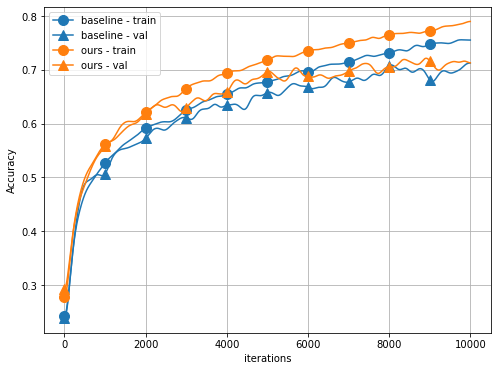

In [ ]:
plt.figure(figsize=(8, 6))
c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']
for index, (c, history) in enumerate(zip(c_vec, history_vec)):
  name = 'baseline' if index == 0 else 'ours'
  plt.plot(gaussian_filter1d(history[:, 2], 100), '-o', c=c, label='%s - train' % name, markevery=1000, markersize=10)
  plt.plot(gaussian_filter1d(history[:, 3], 100), '-^', c=c, label='%s - val' % name, markevery=1000, markersize=10)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

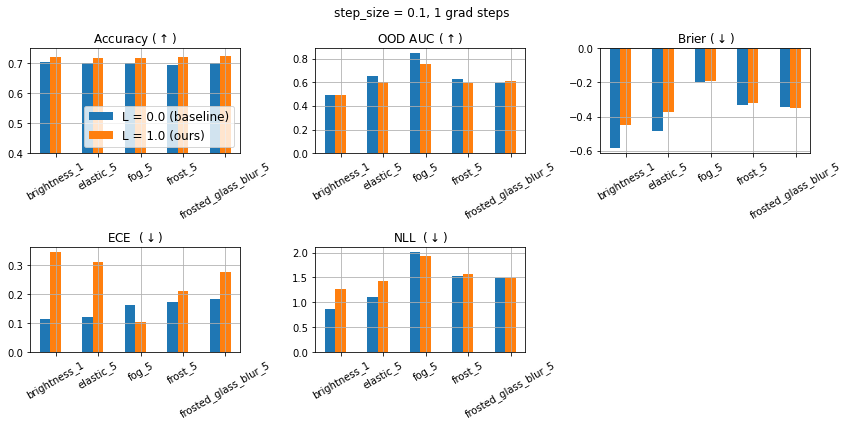

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle('step_size = 0.1, 1 grad steps')
x = np.arange(len(corruption_type_list))
for (index, title) in enumerate(['Accuracy $(\\uparrow)$', 'OOD AUC $(\\uparrow)$', 'Brier $(\\downarrow)$', 'ECE  $(\\downarrow)$', 'NLL  $(\\downarrow)$']):
  plt.subplot(2, 3, index + 1)
  plt.title(title)
  for col,L in enumerate([0.0, 1.0]):
    y = []
    for corruption_type in corruption_type_list:
      y.append(results[(corruption_type, L)][index])
    width = 0.25
    offset = width
    plt.bar(x + width * col - offset, y, width=width, label='L = %s (%s)' % (L, 'ours' if L else 'baseline'))
  plt.xticks(x, corruption_type_list, rotation=30)
  plt.grid()
  if index == 0:
    plt.legend(fontsize=12, loc='lower right')
  if index == 0:
    plt.ylim([0.4, 0.75])
  # else:
  #   plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.show()

### mnist experiments

  0%|          | 0/5000 [00:00<?, ?it/s]

shot_noise 0.0
0.63751220703125

  2%|▏         | 80/5000 [00:04<02:18, 35.51it/s]


0.61834716796875

  4%|▎         | 186/5000 [00:04<00:38, 124.68it/s]


0.63525390625

  6%|▌         | 288/5000 [00:05<00:23, 197.51it/s]


0.606689453125

  8%|▊         | 392/5000 [00:05<00:19, 239.75it/s]


0.622314453125

 10%|▉         | 497/5000 [00:06<00:18, 245.18it/s]


0.69793701171875

 12%|█▏        | 575/5000 [00:06<00:17, 249.87it/s]


0.65631103515625

 14%|█▎        | 681/5000 [00:06<00:16, 256.28it/s]


0.666259765625

 16%|█▌        | 789/5000 [00:07<00:16, 258.35it/s]


0.61541748046875

 18%|█▊        | 894/5000 [00:07<00:16, 251.67it/s]


0.60675048828125

 20%|█▉        | 999/5000 [00:08<00:15, 254.86it/s]


0.68328857421875

 22%|██▏       | 1079/5000 [00:08<00:15, 260.89it/s]


0.63775634765625

 24%|██▍       | 1188/5000 [00:08<00:14, 258.05it/s]


0.67120361328125

 26%|██▌       | 1293/5000 [00:09<00:14, 256.80it/s]


0.694580078125

 28%|██▊       | 1376/5000 [00:09<00:13, 260.52it/s]


0.65716552734375

 30%|██▉       | 1483/5000 [00:09<00:13, 258.04it/s]


0.63409423828125

 32%|███▏      | 1591/5000 [00:10<00:13, 259.46it/s]


0.7000732421875

 34%|███▍      | 1700/5000 [00:10<00:12, 261.07it/s]


0.71295166015625

 36%|███▌      | 1781/5000 [00:11<00:12, 258.52it/s]


0.650146484375

 38%|███▊      | 1888/5000 [00:11<00:12, 259.09it/s]


0.58758544921875

 40%|███▉      | 1996/5000 [00:11<00:11, 261.26it/s]


0.6793212890625

 42%|████▏     | 2079/5000 [00:12<00:11, 264.76it/s]


0.66796875

 44%|████▍     | 2188/5000 [00:12<00:10, 262.26it/s]


0.64910888671875

 46%|████▌     | 2295/5000 [00:13<00:10, 260.47it/s]


0.71124267578125

 48%|████▊     | 2377/5000 [00:13<00:10, 260.45it/s]


0.64239501953125

 50%|████▉     | 2486/5000 [00:13<00:09, 261.89it/s]


0.63751220703125

 52%|█████▏    | 2592/5000 [00:14<00:09, 256.63it/s]


0.6602783203125

 54%|█████▍    | 2698/5000 [00:14<00:08, 257.78it/s]


0.66241455078125

 56%|█████▌    | 2777/5000 [00:14<00:08, 257.54it/s]


0.690673828125

 58%|█████▊    | 2881/5000 [00:15<00:08, 249.85it/s]


0.666015625

 60%|█████▉    | 2988/5000 [00:15<00:07, 258.27it/s]


0.68988037109375

 62%|██████▏   | 3093/5000 [00:16<00:07, 251.12it/s]


0.640625

 64%|██████▍   | 3196/5000 [00:16<00:07, 247.04it/s]


0.66717529296875

 66%|██████▌   | 3298/5000 [00:17<00:06, 248.58it/s]


0.6390380859375

 67%|██████▋   | 3374/5000 [00:17<00:06, 246.80it/s]


0.6961669921875

 70%|██████▉   | 3480/5000 [00:17<00:06, 251.17it/s]


0.628662109375

 72%|███████▏  | 3583/5000 [00:18<00:05, 249.15it/s]


0.61907958984375

 74%|███████▍  | 3689/5000 [00:18<00:05, 256.71it/s]


0.693359375

 76%|███████▌  | 3793/5000 [00:18<00:04, 255.60it/s]


0.66656494140625

 78%|███████▊  | 3899/5000 [00:19<00:04, 257.60it/s]


0.64776611328125

 80%|███████▉  | 3978/5000 [00:19<00:03, 259.22it/s]


0.61334228515625

 82%|████████▏ | 4085/5000 [00:20<00:03, 255.71it/s]


0.6485595703125

 84%|████████▍ | 4189/5000 [00:20<00:03, 254.89it/s]


0.7017822265625

 86%|████████▌ | 4294/5000 [00:20<00:02, 256.20it/s]


0.7099609375

 88%|████████▊ | 4398/5000 [00:21<00:02, 251.23it/s]


0.64508056640625

 90%|████████▉ | 4497/5000 [00:21<00:02, 237.50it/s]


0.7042236328125

 91%|█████████▏| 4573/5000 [00:22<00:01, 244.92it/s]


0.69439697265625

 94%|█████████▍| 4700/5000 [00:22<00:01, 233.84it/s]


0.58843994140625

 96%|█████████▌| 4777/5000 [00:22<00:00, 240.92it/s]


0.62872314453125

 98%|█████████▊| 4882/5000 [00:23<00:00, 248.98it/s]


0.68927001953125

100%|██████████| 5000/5000 [00:23<00:00, 209.85it/s]

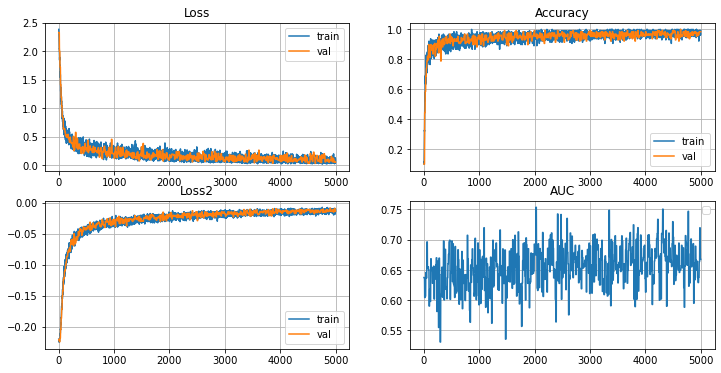

  0%|          | 0/5000 [00:00<?, ?it/s]

shot_noise 100.0
0.5322265625

  2%|▏         | 99/5000 [00:01<00:34, 140.76it/s]


0.58013916015625

  4%|▍         | 195/5000 [00:01<00:23, 208.11it/s]


0.658447265625

  6%|▌         | 298/5000 [00:02<00:19, 239.36it/s]


0.62060546875

  8%|▊         | 400/5000 [00:02<00:18, 245.24it/s]


0.6439208984375

 10%|▉         | 476/5000 [00:02<00:18, 242.31it/s]


0.67901611328125

 12%|█▏        | 579/5000 [00:03<00:17, 251.64it/s]


0.68505859375

 14%|█▎        | 684/5000 [00:03<00:17, 252.34it/s]


0.6072998046875

 16%|█▌        | 789/5000 [00:03<00:16, 254.20it/s]


0.6090087890625

 18%|█▊        | 893/5000 [00:04<00:16, 253.78it/s]


0.73614501953125

 20%|█▉        | 996/5000 [00:04<00:16, 249.11it/s]


0.7103271484375

 22%|██▏       | 1098/5000 [00:05<00:15, 247.16it/s]


0.6611328125

 24%|██▍       | 1199/5000 [00:05<00:15, 246.61it/s]


0.69183349609375

 26%|██▌       | 1275/5000 [00:05<00:15, 245.06it/s]


0.732025146484375

 28%|██▊       | 1380/5000 [00:06<00:14, 253.25it/s]


0.56512451171875

 30%|██▉       | 1484/5000 [00:06<00:13, 251.84it/s]


0.6634521484375

 32%|███▏      | 1590/5000 [00:07<00:13, 254.73it/s]


0.69036865234375

 34%|███▍      | 1695/5000 [00:07<00:13, 254.20it/s]


0.72796630859375

 35%|███▌      | 1774/5000 [00:07<00:12, 256.15it/s]


0.77435302734375

 38%|███▊      | 1881/5000 [00:08<00:12, 253.91it/s]


0.72406005859375

 40%|███▉      | 1985/5000 [00:08<00:11, 253.62it/s]


0.7420654296875

 42%|████▏     | 2090/5000 [00:09<00:11, 251.52it/s]


0.7161865234375

 44%|████▍     | 2195/5000 [00:09<00:10, 255.82it/s]


0.68572998046875

 45%|████▌     | 2274/5000 [00:09<00:10, 259.25it/s]


0.745361328125

 48%|████▊     | 2381/5000 [00:10<00:10, 255.51it/s]


0.736572265625

 50%|████▉     | 2486/5000 [00:10<00:09, 255.38it/s]


0.76153564453125

 52%|█████▏    | 2591/5000 [00:11<00:09, 252.92it/s]


0.6522216796875

 54%|█████▍    | 2696/5000 [00:11<00:09, 254.75it/s]


0.7301025390625

 55%|█████▌    | 2774/5000 [00:11<00:08, 252.60it/s]


0.667327880859375

 58%|█████▊    | 2880/5000 [00:12<00:08, 251.85it/s]


0.74456787109375

 60%|█████▉    | 2985/5000 [00:12<00:07, 251.92it/s]


0.659210205078125

 62%|██████▏   | 3090/5000 [00:13<00:07, 257.53it/s]


0.74041748046875

 64%|██████▍   | 3195/5000 [00:13<00:07, 254.90it/s]


0.74493408203125

 65%|██████▌   | 3274/5000 [00:13<00:06, 256.51it/s]


0.70697021484375

 68%|██████▊   | 3380/5000 [00:14<00:06, 257.36it/s]


0.68988037109375

 70%|██████▉   | 3484/5000 [00:14<00:05, 253.78it/s]


0.73455810546875

 72%|███████▏  | 3589/5000 [00:15<00:05, 257.48it/s]


0.7725830078125

 74%|███████▍  | 3694/5000 [00:15<00:05, 255.58it/s]


0.727752685546875

 76%|███████▌  | 3800/5000 [00:15<00:04, 254.66it/s]


0.71136474609375

 78%|███████▊  | 3878/5000 [00:16<00:04, 252.57it/s]


0.7857666015625

 80%|███████▉  | 3984/5000 [00:16<00:03, 256.13it/s]


0.75390625

 82%|████████▏ | 4089/5000 [00:16<00:03, 258.53it/s]


0.7059326171875

 84%|████████▍ | 4195/5000 [00:17<00:03, 255.69it/s]


0.71319580078125

 86%|████████▌ | 4299/5000 [00:17<00:02, 253.13it/s]


0.805908203125

 88%|████████▊ | 4378/5000 [00:18<00:02, 254.14it/s]


0.7833251953125

 90%|████████▉ | 4483/5000 [00:18<00:02, 253.05it/s]


0.75067138671875

 92%|█████████▏| 4588/5000 [00:18<00:01, 257.25it/s]


0.74072265625

 94%|█████████▍| 4693/5000 [00:19<00:01, 249.45it/s]


0.73199462890625

 96%|█████████▌| 4799/5000 [00:19<00:00, 256.88it/s]


0.78289794921875

 98%|█████████▊| 4877/5000 [00:20<00:00, 257.27it/s]


0.753662109375

100%|██████████| 5000/5000 [00:20<00:00, 243.15it/s]

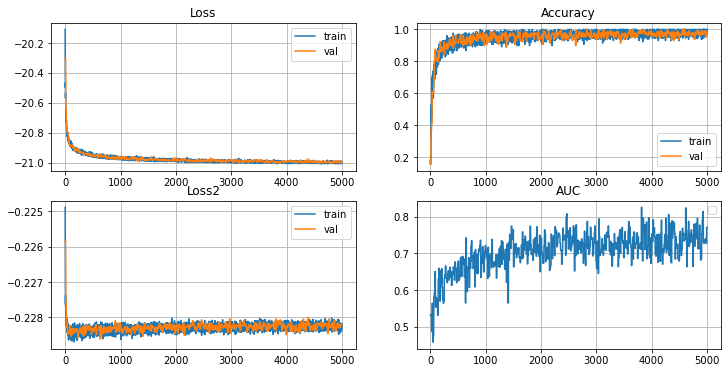

  0%|          | 0/5000 [00:00<?, ?it/s]

impulse_noise 0.0
0.260498046875

  2%|▏         | 81/5000 [00:05<02:42, 30.28it/s]


0.628173828125

  4%|▍         | 188/5000 [00:05<00:42, 113.83it/s]


0.64154052734375

  6%|▌         | 293/5000 [00:06<00:23, 197.43it/s]


0.641357421875

  8%|▊         | 375/5000 [00:06<00:19, 237.90it/s]


0.66900634765625

 10%|▉         | 481/5000 [00:06<00:18, 241.81it/s]


0.6737060546875

 12%|█▏        | 588/5000 [00:07<00:17, 256.02it/s]


0.6990966796875

 14%|█▍        | 693/5000 [00:07<00:16, 255.42it/s]


0.73443603515625

 15%|█▌        | 773/5000 [00:07<00:16, 250.80it/s]


0.71075439453125

 18%|█▊        | 881/5000 [00:08<00:16, 256.70it/s]


0.67303466796875

 20%|█▉        | 990/5000 [00:08<00:15, 258.66it/s]


0.7081298828125

 22%|██▏       | 1097/5000 [00:09<00:14, 262.94it/s]


0.72918701171875

 24%|██▎       | 1179/5000 [00:09<00:14, 263.17it/s]


0.699462890625

 26%|██▌       | 1286/5000 [00:09<00:14, 259.21it/s]


0.68951416015625

 28%|██▊       | 1394/5000 [00:10<00:13, 262.14it/s]


0.75213623046875

 30%|███       | 1500/5000 [00:10<00:13, 259.65it/s]


0.74603271484375

 32%|███▏      | 1581/5000 [00:11<00:13, 260.95it/s]


0.7266845703125

 34%|███▍      | 1690/5000 [00:11<00:12, 261.80it/s]


0.73846435546875

 36%|███▌      | 1797/5000 [00:11<00:12, 260.79it/s]


0.7640380859375

 38%|███▊      | 1878/5000 [00:12<00:12, 260.09it/s]


0.7696533203125

 40%|███▉      | 1986/5000 [00:12<00:11, 260.09it/s]


0.740478515625

 42%|████▏     | 2094/5000 [00:13<00:11, 258.98it/s]


0.71441650390625

 43%|████▎     | 2174/5000 [00:13<00:10, 259.19it/s]


0.721923828125

 46%|████▌     | 2283/5000 [00:13<00:10, 259.04it/s]


0.77825927734375

 48%|████▊     | 2391/5000 [00:14<00:10, 257.91it/s]


0.74505615234375

 50%|████▉     | 2498/5000 [00:14<00:09, 262.39it/s]


0.76971435546875

 52%|█████▏    | 2580/5000 [00:14<00:09, 263.86it/s]


0.77825927734375

 54%|█████▍    | 2688/5000 [00:15<00:08, 262.23it/s]


0.77764892578125

 56%|█████▌    | 2796/5000 [00:15<00:08, 260.54it/s]


0.741455078125

 58%|█████▊    | 2878/5000 [00:16<00:08, 263.27it/s]


0.7601318359375

 60%|█████▉    | 2987/5000 [00:16<00:07, 263.00it/s]


0.74932861328125

 62%|██████▏   | 3095/5000 [00:16<00:07, 261.93it/s]


0.7685546875

 64%|██████▎   | 3176/5000 [00:17<00:06, 260.97it/s]


0.7861328125

 66%|██████▌   | 3284/5000 [00:17<00:06, 261.80it/s]


0.72491455078125

 68%|██████▊   | 3391/5000 [00:18<00:06, 257.34it/s]


0.77178955078125

 70%|██████▉   | 3495/5000 [00:18<00:05, 253.84it/s]


0.73687744140625

 72%|███████▏  | 3577/5000 [00:18<00:05, 261.55it/s]


0.73919677734375

 74%|███████▎  | 3684/5000 [00:19<00:05, 258.61it/s]


0.76641845703125

 76%|███████▌  | 3792/5000 [00:19<00:04, 259.87it/s]


0.7816162109375

 78%|███████▊  | 3899/5000 [00:19<00:04, 260.94it/s]


0.7930908203125

 80%|███████▉  | 3979/5000 [00:20<00:03, 261.46it/s]


0.795654296875

 82%|████████▏ | 4087/5000 [00:20<00:03, 261.96it/s]


0.75360107421875

 84%|████████▍ | 4196/5000 [00:21<00:03, 261.99it/s]


0.845947265625

 86%|████████▌ | 4277/5000 [00:21<00:02, 257.99it/s]


0.82354736328125

 88%|████████▊ | 4382/5000 [00:21<00:02, 258.07it/s]


0.749755859375

 90%|████████▉ | 4489/5000 [00:22<00:01, 259.59it/s]


0.701904296875

 92%|█████████▏| 4594/5000 [00:22<00:01, 256.49it/s]


0.74053955078125

 94%|█████████▎| 4676/5000 [00:22<00:01, 256.17it/s]


0.764892578125

 96%|█████████▌| 4781/5000 [00:23<00:00, 257.99it/s]


0.80389404296875

 98%|█████████▊| 4890/5000 [00:23<00:00, 260.72it/s]


0.76800537109375

100%|██████████| 5000/5000 [00:24<00:00, 206.31it/s]

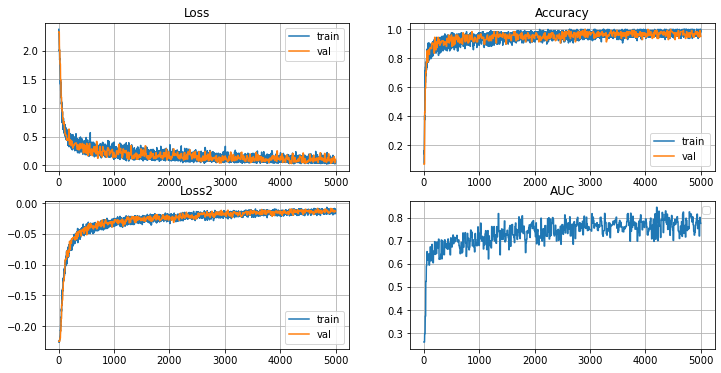

  0%|          | 0/5000 [00:00<?, ?it/s]

impulse_noise 100.0
0.29107666015625

  2%|▏         | 78/5000 [00:00<00:34, 142.11it/s]


0.30194091796875

  4%|▎         | 184/5000 [00:01<00:21, 227.48it/s]


0.513916015625

  6%|▌         | 291/5000 [00:01<00:18, 250.58it/s]


0.62725830078125

  8%|▊         | 398/5000 [00:02<00:17, 259.31it/s]


0.80914306640625

 10%|▉         | 478/5000 [00:02<00:17, 258.77it/s]


0.82421875

 12%|█▏        | 584/5000 [00:02<00:17, 255.34it/s]


0.861358642578125

 14%|█▍        | 690/5000 [00:03<00:16, 258.28it/s]


0.9072265625

 16%|█▌        | 795/5000 [00:03<00:16, 254.81it/s]


0.95013427734375

 17%|█▋        | 874/5000 [00:03<00:16, 255.32it/s]


0.95703125

 20%|█▉        | 980/5000 [00:04<00:15, 255.67it/s]


0.961181640625

 22%|██▏       | 1085/5000 [00:04<00:15, 258.83it/s]


0.9873046875

 24%|██▍       | 1190/5000 [00:05<00:14, 254.35it/s]


0.97564697265625

 26%|██▌       | 1295/5000 [00:05<00:14, 254.31it/s]


0.9874267578125

 28%|██▊       | 1400/5000 [00:05<00:13, 258.37it/s]


0.9857177734375

 30%|██▉       | 1479/5000 [00:06<00:13, 255.26it/s]


0.9874267578125

 32%|███▏      | 1586/5000 [00:06<00:13, 259.95it/s]


0.99383544921875

 34%|███▍      | 1692/5000 [00:07<00:12, 255.67it/s]


0.99658203125

 36%|███▌      | 1798/5000 [00:07<00:12, 257.83it/s]


0.9952392578125

 38%|███▊      | 1878/5000 [00:07<00:12, 258.56it/s]


0.9959716796875

 40%|███▉      | 1983/5000 [00:08<00:11, 254.36it/s]


0.9951171875

 42%|████▏     | 2089/5000 [00:08<00:11, 258.23it/s]


0.989990234375

 44%|████▍     | 2194/5000 [00:09<00:10, 256.37it/s]


0.9993896484375

 45%|████▌     | 2274/5000 [00:09<00:10, 258.33it/s]


0.99554443359375

 48%|████▊     | 2381/5000 [00:09<00:10, 253.82it/s]


0.9971923828125

 50%|████▉     | 2488/5000 [00:10<00:09, 260.28it/s]


0.9984130859375

 52%|█████▏    | 2594/5000 [00:10<00:09, 256.51it/s]


0.99822998046875

 54%|█████▎    | 2675/5000 [00:10<00:09, 257.01it/s]


0.9989013671875

 56%|█████▌    | 2781/5000 [00:11<00:08, 255.94it/s]


0.995849609375

 58%|█████▊    | 2888/5000 [00:11<00:08, 256.81it/s]


0.99908447265625

 60%|█████▉    | 2994/5000 [00:12<00:07, 257.84it/s]


0.9976806640625

 61%|██████▏   | 3074/5000 [00:12<00:07, 257.88it/s]


0.99822998046875

 64%|██████▎   | 3180/5000 [00:12<00:07, 254.76it/s]


1.0

 66%|██████▌   | 3286/5000 [00:13<00:06, 251.76it/s]


0.9969482421875

 68%|██████▊   | 3391/5000 [00:13<00:06, 254.26it/s]


0.9976806640625

 70%|██████▉   | 3498/5000 [00:14<00:05, 256.13it/s]


0.997802734375

 72%|███████▏  | 3578/5000 [00:14<00:05, 258.34it/s]


0.99859619140625

 74%|███████▎  | 3684/5000 [00:14<00:05, 255.00it/s]


0.99957275390625

 76%|███████▌  | 3790/5000 [00:15<00:04, 257.83it/s]


0.99859619140625

 78%|███████▊  | 3895/5000 [00:15<00:04, 251.73it/s]


0.99786376953125

 80%|████████  | 4000/5000 [00:16<00:03, 254.86it/s]


0.99859619140625

 82%|████████▏ | 4078/5000 [00:16<00:03, 251.45it/s]


0.999755859375

 84%|████████▎ | 4183/5000 [00:16<00:03, 251.97it/s]


0.99798583984375

 86%|████████▌ | 4289/5000 [00:17<00:02, 256.29it/s]


0.9986572265625

 88%|████████▊ | 4393/5000 [00:17<00:02, 254.87it/s]


0.999755859375

 90%|████████▉ | 4499/5000 [00:18<00:01, 258.29it/s]


0.99810791015625

 92%|█████████▏| 4578/5000 [00:18<00:01, 252.10it/s]


0.99908447265625

 94%|█████████▎| 4682/5000 [00:18<00:01, 253.31it/s]


0.998291015625

 96%|█████████▌| 4788/5000 [00:19<00:00, 255.45it/s]


0.998046875

 98%|█████████▊| 4893/5000 [00:19<00:00, 252.48it/s]


0.99957275390625

100%|██████████| 5000/5000 [00:20<00:00, 249.09it/s]

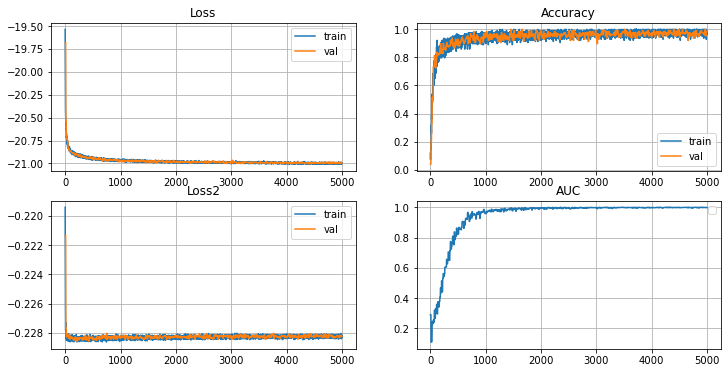

  0%|          | 0/5000 [00:00<?, ?it/s]

rotate 0.0
0.51812744140625

  2%|▏         | 79/5000 [00:06<03:12, 25.59it/s]


0.74176025390625

  4%|▎         | 184/5000 [00:06<00:47, 100.76it/s]


0.68646240234375

  6%|▌         | 293/5000 [00:06<00:24, 195.29it/s]


0.64208984375

  7%|▋         | 374/5000 [00:07<00:19, 232.54it/s]


0.739501953125

 10%|▉         | 482/5000 [00:07<00:18, 247.44it/s]


0.718505859375

 12%|█▏        | 588/5000 [00:08<00:17, 252.42it/s]


0.7451171875

 14%|█▍        | 695/5000 [00:08<00:16, 260.80it/s]


0.655029296875

 16%|█▌        | 776/5000 [00:08<00:16, 259.17it/s]


0.657958984375

 18%|█▊        | 883/5000 [00:09<00:15, 260.05it/s]


0.6717529296875

 20%|█▉        | 989/5000 [00:09<00:15, 255.25it/s]


0.67718505859375

 22%|██▏       | 1096/5000 [00:10<00:15, 258.72it/s]


0.73046875

 24%|██▎       | 1179/5000 [00:10<00:14, 265.01it/s]


0.72052001953125

 26%|██▌       | 1289/5000 [00:10<00:13, 265.22it/s]


0.67510986328125

 28%|██▊       | 1397/5000 [00:11<00:13, 257.42it/s]


0.6202392578125

 30%|██▉       | 1476/5000 [00:11<00:13, 256.20it/s]


0.657958984375

 32%|███▏      | 1582/5000 [00:11<00:13, 251.38it/s]


0.781005859375

 34%|███▎      | 1687/5000 [00:12<00:13, 252.62it/s]


0.674560546875

 36%|███▌      | 1792/5000 [00:12<00:12, 257.76it/s]


0.72802734375

 38%|███▊      | 1899/5000 [00:13<00:11, 261.87it/s]


0.632568359375

 40%|███▉      | 1980/5000 [00:13<00:11, 262.53it/s]


0.73583984375

 42%|████▏     | 2088/5000 [00:13<00:11, 259.41it/s]


0.7762451171875

 44%|████▍     | 2195/5000 [00:14<00:10, 257.45it/s]


0.7200927734375

 46%|████▌     | 2275/5000 [00:14<00:10, 257.09it/s]


0.78997802734375

 48%|████▊     | 2382/5000 [00:15<00:10, 258.62it/s]


0.7088623046875

 50%|████▉     | 2491/5000 [00:15<00:09, 259.50it/s]


0.6934814453125

 52%|█████▏    | 2600/5000 [00:15<00:09, 265.04it/s]


0.69647216796875

 54%|█████▎    | 2681/5000 [00:16<00:08, 264.03it/s]


0.75592041015625

 56%|█████▌    | 2788/5000 [00:16<00:08, 254.46it/s]


0.72442626953125

 58%|█████▊    | 2897/5000 [00:17<00:08, 261.37it/s]


0.7166748046875

 60%|█████▉    | 2979/5000 [00:17<00:07, 264.27it/s]


0.65704345703125

 62%|██████▏   | 3085/5000 [00:17<00:07, 252.69it/s]


0.6563720703125

 64%|██████▍   | 3191/5000 [00:18<00:07, 256.50it/s]


0.733642578125

 66%|██████▌   | 3298/5000 [00:18<00:06, 262.41it/s]


0.744873046875

 68%|██████▊   | 3379/5000 [00:18<00:06, 261.11it/s]


0.70721435546875

 70%|██████▉   | 3487/5000 [00:19<00:05, 260.60it/s]


0.71331787109375

 72%|███████▏  | 3596/5000 [00:19<00:05, 262.95it/s]


0.7572021484375

 74%|███████▎  | 3678/5000 [00:20<00:05, 262.49it/s]


0.7535400390625

 76%|███████▌  | 3784/5000 [00:20<00:04, 257.30it/s]


0.67083740234375

 78%|███████▊  | 3890/5000 [00:20<00:04, 257.71it/s]


0.69866943359375

 80%|███████▉  | 3995/5000 [00:21<00:03, 257.65it/s]


0.7269287109375

 82%|████████▏ | 4077/5000 [00:21<00:03, 261.62it/s]


0.67724609375

 84%|████████▎ | 4185/5000 [00:21<00:03, 261.49it/s]


0.71649169921875

 86%|████████▌ | 4291/5000 [00:22<00:02, 250.93it/s]


0.67572021484375

 88%|████████▊ | 4398/5000 [00:22<00:02, 257.84it/s]


0.7001953125

 90%|████████▉ | 4479/5000 [00:23<00:01, 263.80it/s]


0.722900390625

 92%|█████████▏| 4586/5000 [00:23<00:01, 256.98it/s]


0.73638916015625

 94%|█████████▍| 4691/5000 [00:23<00:01, 254.79it/s]


0.72613525390625

 96%|█████████▌| 4798/5000 [00:24<00:00, 260.68it/s]


0.68243408203125

 98%|█████████▊| 4879/5000 [00:24<00:00, 260.63it/s]


0.69500732421875

100%|██████████| 5000/5000 [00:25<00:00, 198.85it/s]

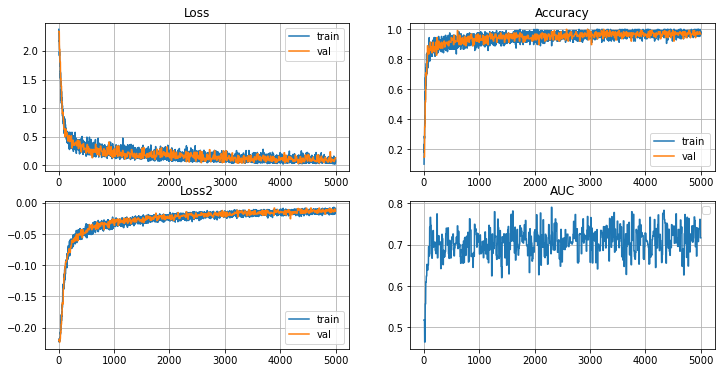

  0%|          | 0/5000 [00:00<?, ?it/s]

rotate 100.0
0.61700439453125

  2%|▏         | 79/5000 [00:00<00:33, 145.32it/s]


0.66314697265625

  4%|▎         | 183/5000 [00:01<00:21, 225.57it/s]


0.71478271484375

  6%|▌         | 289/5000 [00:01<00:18, 252.01it/s]


0.74700927734375

  8%|▊         | 394/5000 [00:02<00:17, 256.78it/s]


0.72357177734375

 10%|▉         | 499/5000 [00:02<00:17, 259.60it/s]


0.726318359375

 12%|█▏        | 579/5000 [00:02<00:16, 261.77it/s]


0.74822998046875

 14%|█▍        | 688/5000 [00:03<00:16, 262.35it/s]


0.77783203125

 16%|█▌        | 796/5000 [00:03<00:16, 260.14it/s]


0.77593994140625

 18%|█▊        | 877/5000 [00:03<00:15, 258.79it/s]


0.7781982421875

 20%|█▉        | 982/5000 [00:04<00:15, 256.70it/s]


0.8111572265625

 22%|██▏       | 1087/5000 [00:04<00:15, 257.89it/s]


0.7979736328125

 24%|██▍       | 1193/5000 [00:05<00:14, 257.50it/s]


0.789794921875

 25%|██▌       | 1273/5000 [00:05<00:14, 257.93it/s]


0.728790283203125

 28%|██▊       | 1381/5000 [00:05<00:13, 258.94it/s]


0.68963623046875

 30%|██▉       | 1487/5000 [00:06<00:13, 259.28it/s]


0.77197265625

 32%|███▏      | 1593/5000 [00:06<00:13, 258.70it/s]


0.79144287109375

 34%|███▎      | 1675/5000 [00:06<00:12, 258.90it/s]


0.76806640625

 36%|███▌      | 1780/5000 [00:07<00:12, 256.38it/s]


0.79376220703125

 38%|███▊      | 1885/5000 [00:07<00:12, 253.71it/s]


0.72015380859375

 40%|███▉      | 1991/5000 [00:08<00:11, 257.21it/s]


0.72247314453125

 42%|████▏     | 2096/5000 [00:08<00:11, 255.35it/s]


0.7509765625

 44%|████▎     | 2175/5000 [00:08<00:11, 253.86it/s]


0.7935791015625

 46%|████▌     | 2281/5000 [00:09<00:10, 254.79it/s]


0.79071044921875

 48%|████▊     | 2387/5000 [00:09<00:10, 254.57it/s]


0.75732421875

 50%|████▉     | 2494/5000 [00:10<00:09, 256.41it/s]


0.80938720703125

 51%|█████▏    | 2574/5000 [00:10<00:09, 258.87it/s]


0.79986572265625

 54%|█████▎    | 2681/5000 [00:10<00:08, 258.21it/s]


0.84173583984375

 56%|█████▌    | 2788/5000 [00:11<00:08, 262.82it/s]


0.80584716796875

 58%|█████▊    | 2893/5000 [00:11<00:08, 255.91it/s]


0.8331298828125

 60%|█████▉    | 2999/5000 [00:12<00:07, 258.59it/s]


0.791107177734375

 62%|██████▏   | 3077/5000 [00:12<00:07, 252.55it/s]


0.76373291015625

 64%|██████▎   | 3182/5000 [00:12<00:07, 256.21it/s]


0.7822265625

 66%|██████▌   | 3287/5000 [00:13<00:06, 257.62it/s]


0.79425048828125

 68%|██████▊   | 3391/5000 [00:13<00:06, 254.75it/s]


0.82391357421875

 70%|██████▉   | 3496/5000 [00:14<00:05, 251.33it/s]


0.8291015625

 72%|███████▏  | 3575/5000 [00:14<00:05, 254.05it/s]


0.767822265625

 74%|███████▎  | 3681/5000 [00:14<00:05, 256.65it/s]


0.76177978515625

 76%|███████▌  | 3787/5000 [00:15<00:04, 257.21it/s]


0.781005859375

 78%|███████▊  | 3891/5000 [00:15<00:04, 247.33it/s]


0.73126220703125

 80%|███████▉  | 3994/5000 [00:16<00:04, 235.93it/s]


0.818359375

 82%|████████▏ | 4089/5000 [00:16<00:03, 228.68it/s]


0.75848388671875

 84%|████████▎ | 4185/5000 [00:16<00:03, 230.50it/s]


0.77423095703125

 86%|████████▌ | 4281/5000 [00:17<00:03, 229.26it/s]


0.7547607421875

 88%|████████▊ | 4400/5000 [00:17<00:02, 229.42it/s]


0.78985595703125

 90%|████████▉ | 4493/5000 [00:18<00:02, 225.74it/s]


0.810302734375

 92%|█████████▏| 4585/5000 [00:18<00:01, 223.36it/s]


0.75457763671875

 94%|█████████▍| 4700/5000 [00:19<00:01, 222.74it/s]


0.7064208984375

 96%|█████████▌| 4793/5000 [00:19<00:00, 224.95it/s]


0.80206298828125

 98%|█████████▊| 4889/5000 [00:20<00:00, 229.25it/s]


0.7630615234375

100%|██████████| 5000/5000 [00:20<00:00, 243.60it/s]

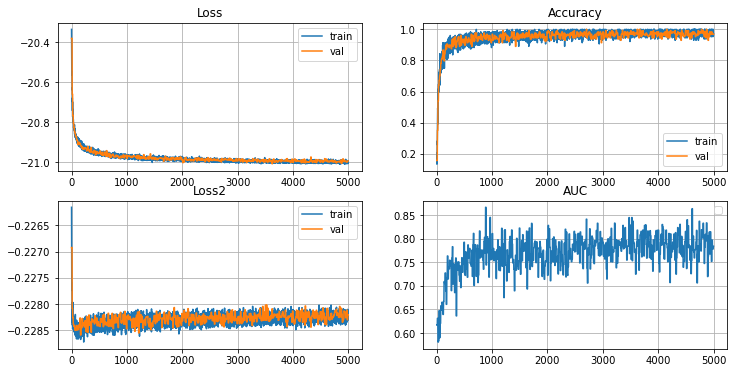

  0%|          | 0/5000 [00:00<?, ?it/s]

canny_edges 0.0
0.4100341796875

  2%|▏         | 97/5000 [00:05<02:07, 38.42it/s]


0.92498779296875

  4%|▍         | 192/5000 [00:06<00:41, 116.84it/s]


0.8922119140625

  6%|▌         | 289/5000 [00:06<00:24, 191.86it/s]


0.86529541015625

  8%|▊         | 385/5000 [00:07<00:20, 220.28it/s]


0.8560791015625

 10%|▉         | 482/5000 [00:07<00:20, 221.34it/s]


0.863037109375

 12%|█▏        | 599/5000 [00:08<00:19, 227.49it/s]


0.8603515625

 14%|█▍        | 692/5000 [00:08<00:19, 225.64it/s]


0.8428955078125

 16%|█▌        | 789/5000 [00:08<00:18, 233.22it/s]


0.83782958984375

 18%|█▊        | 886/5000 [00:09<00:17, 233.91it/s]


0.8787841796875

 20%|█▉        | 981/5000 [00:09<00:17, 226.97it/s]


0.8873291015625

 22%|██▏       | 1078/5000 [00:10<00:16, 233.92it/s]


0.881591796875

 24%|██▍       | 1198/5000 [00:10<00:16, 232.99it/s]


0.88067626953125

 26%|██▌       | 1294/5000 [00:11<00:16, 230.05it/s]


0.88067626953125

 28%|██▊       | 1391/5000 [00:11<00:15, 226.78it/s]


0.86724853515625

 30%|██▉       | 1487/5000 [00:11<00:15, 231.47it/s]


0.8717041015625

 32%|███▏      | 1583/5000 [00:12<00:14, 228.43it/s]


0.836181640625

 34%|███▎      | 1680/5000 [00:12<00:14, 233.60it/s]


0.89044189453125

 36%|███▌      | 1800/5000 [00:13<00:13, 230.55it/s]


0.87542724609375

 38%|███▊      | 1897/5000 [00:13<00:13, 231.93it/s]


0.87384033203125

 40%|███▉      | 1993/5000 [00:14<00:13, 227.66it/s]


0.8680419921875

 42%|████▏     | 2091/5000 [00:14<00:12, 232.44it/s]


0.88836669921875

 44%|████▎     | 2187/5000 [00:14<00:12, 230.00it/s]


0.861572265625

 46%|████▌     | 2283/5000 [00:15<00:11, 230.38it/s]


0.86627197265625

 48%|████▊     | 2379/5000 [00:15<00:11, 232.31it/s]


0.84283447265625

 50%|████▉     | 2476/5000 [00:16<00:10, 235.00it/s]


0.9246826171875

 52%|█████▏    | 2597/5000 [00:16<00:10, 233.84it/s]


0.88067626953125

 54%|█████▍    | 2694/5000 [00:17<00:09, 233.43it/s]


0.85687255859375

 56%|█████▌    | 2791/5000 [00:17<00:09, 230.28it/s]


0.87445068359375

 58%|█████▊    | 2892/5000 [00:17<00:08, 244.21it/s]


0.86181640625

 60%|█████▉    | 2996/5000 [00:18<00:07, 251.84it/s]


0.88671875

 62%|██████▏   | 3096/5000 [00:18<00:08, 237.76it/s]


0.8834228515625

 64%|██████▍   | 3192/5000 [00:19<00:07, 232.33it/s]


0.85260009765625

 66%|██████▌   | 3295/5000 [00:19<00:07, 242.08it/s]


0.89373779296875

 68%|██████▊   | 3393/5000 [00:20<00:06, 232.71it/s]


0.85870361328125

 70%|██████▉   | 3489/5000 [00:20<00:06, 231.69it/s]


0.8963623046875

 72%|███████▏  | 3585/5000 [00:20<00:06, 230.99it/s]


0.87286376953125

 74%|███████▎  | 3683/5000 [00:21<00:05, 229.72it/s]


0.87603759765625

 76%|███████▌  | 3784/5000 [00:21<00:04, 245.24it/s]


0.91510009765625

 78%|███████▊  | 3890/5000 [00:22<00:04, 246.49it/s]


0.9039306640625

 80%|███████▉  | 3985/5000 [00:22<00:04, 223.06it/s]


0.85980224609375

 82%|████████▏ | 4100/5000 [00:23<00:04, 220.88it/s]


0.88128662109375

 84%|████████▍ | 4190/5000 [00:23<00:03, 219.37it/s]


0.869384765625

 86%|████████▌ | 4280/5000 [00:23<00:03, 220.43it/s]


0.89569091796875

 88%|████████▊ | 4392/5000 [00:24<00:02, 217.11it/s]


0.845703125

 90%|████████▉ | 4484/5000 [00:24<00:02, 218.63it/s]


0.84869384765625

 92%|█████████▏| 4597/5000 [00:25<00:01, 217.41it/s]


0.84375

 94%|█████████▍| 4688/5000 [00:25<00:01, 221.96it/s]


0.87359619140625

 96%|█████████▌| 4780/5000 [00:26<00:01, 218.45it/s]


0.87506103515625

 98%|█████████▊| 4895/5000 [00:26<00:00, 219.54it/s]


0.89483642578125

100%|██████████| 5000/5000 [00:27<00:00, 183.60it/s]

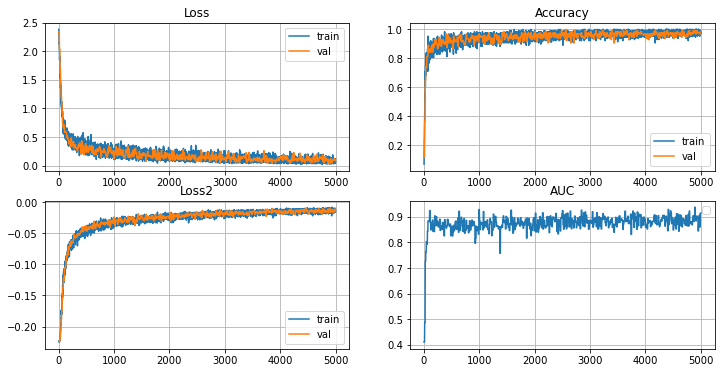

  0%|          | 0/5000 [00:00<?, ?it/s]

canny_edges 100.0
0.49310302734375

  2%|▏         | 91/5000 [00:01<00:35, 139.41it/s]


0.46783447265625

  4%|▎         | 181/5000 [00:01<00:24, 196.55it/s]


0.56048583984375

  6%|▌         | 294/5000 [00:01<00:21, 214.86it/s]


0.677001953125

  8%|▊         | 385/5000 [00:02<00:21, 217.44it/s]


0.73992919921875

 10%|█         | 500/5000 [00:02<00:20, 222.23it/s]


0.77886962890625

 12%|█▏        | 590/5000 [00:03<00:20, 219.66it/s]


0.80303955078125

 14%|█▎        | 681/5000 [00:03<00:19, 219.11it/s]


0.8050537109375

 16%|█▌        | 793/5000 [00:04<00:19, 216.56it/s]


0.784332275390625

 18%|█▊        | 882/5000 [00:04<00:19, 210.48it/s]


0.8770751953125

 20%|█▉        | 994/5000 [00:05<00:18, 213.53it/s]


0.89483642578125

 22%|██▏       | 1083/5000 [00:05<00:18, 215.84it/s]


0.87872314453125

 24%|██▍       | 1196/5000 [00:06<00:17, 218.85it/s]


0.902099609375

 26%|██▌       | 1285/5000 [00:06<00:17, 217.10it/s]


0.8680419921875

 28%|██▊       | 1399/5000 [00:07<00:16, 220.51it/s]


0.9012451171875

 30%|██▉       | 1491/5000 [00:07<00:16, 214.66it/s]


0.8458251953125

 32%|███▏      | 1580/5000 [00:07<00:15, 218.00it/s]


0.88043212890625

 34%|███▍      | 1691/5000 [00:08<00:15, 214.81it/s]


0.91387939453125

 36%|███▌      | 1781/5000 [00:08<00:14, 215.93it/s]


0.88232421875

 38%|███▊      | 1894/5000 [00:09<00:14, 217.26it/s]


0.90704345703125

 40%|███▉      | 1985/5000 [00:09<00:13, 216.83it/s]


0.906494140625

 42%|████▏     | 2100/5000 [00:10<00:13, 222.20it/s]


0.90899658203125

 44%|████▍     | 2190/5000 [00:10<00:12, 217.83it/s]


0.901611328125

 46%|████▌     | 2300/5000 [00:11<00:12, 216.94it/s]


0.93145751953125

 48%|████▊     | 2390/5000 [00:11<00:11, 217.87it/s]


0.90277099609375

 50%|█████     | 2500/5000 [00:12<00:11, 215.21it/s]


0.90130615234375

 52%|█████▏    | 2590/5000 [00:12<00:11, 219.04it/s]


0.92999267578125

 54%|█████▎    | 2682/5000 [00:12<00:10, 222.13it/s]


0.9283447265625

 56%|█████▌    | 2797/5000 [00:13<00:09, 220.74it/s]


0.91241455078125

 58%|█████▊    | 2886/5000 [00:13<00:09, 215.47it/s]


0.9307861328125

 60%|█████▉    | 2998/5000 [00:14<00:09, 219.04it/s]


0.92144775390625

 62%|██████▏   | 3090/5000 [00:14<00:08, 221.45it/s]


0.908935546875

 64%|██████▎   | 3182/5000 [00:15<00:08, 216.66it/s]


0.90997314453125

 66%|██████▌   | 3294/5000 [00:15<00:07, 219.41it/s]


0.9317626953125

 68%|██████▊   | 3385/5000 [00:16<00:07, 217.36it/s]


0.90509033203125

 70%|██████▉   | 3497/5000 [00:16<00:06, 219.35it/s]


0.93365478515625

 72%|███████▏  | 3585/5000 [00:17<00:06, 214.96it/s]


0.925537109375

 74%|███████▍  | 3695/5000 [00:17<00:06, 211.82it/s]


0.9462890625

 76%|███████▌  | 3784/5000 [00:18<00:05, 215.91it/s]


0.9312744140625

 78%|███████▊  | 3897/5000 [00:18<00:05, 219.51it/s]


0.9365234375

 80%|███████▉  | 3986/5000 [00:18<00:04, 216.89it/s]


0.92822265625

 82%|████████▏ | 4098/5000 [00:19<00:04, 218.71it/s]


0.9583740234375

 84%|████████▎ | 4186/5000 [00:19<00:03, 215.67it/s]


0.937103271484375

 86%|████████▌ | 4299/5000 [00:20<00:03, 218.93it/s]


0.95184326171875

 88%|████████▊ | 4390/5000 [00:20<00:02, 220.99it/s]


0.94921875

 90%|████████▉ | 4480/5000 [00:21<00:02, 218.54it/s]


0.942138671875

 92%|█████████▏| 4590/5000 [00:21<00:01, 214.26it/s]


0.93853759765625

 94%|█████████▎| 4679/5000 [00:22<00:01, 217.22it/s]


0.90643310546875

 96%|█████████▌| 4791/5000 [00:22<00:00, 217.90it/s]


0.94696044921875

 98%|█████████▊| 4880/5000 [00:23<00:00, 216.87it/s]


0.93157958984375

100%|██████████| 5000/5000 [00:23<00:00, 211.69it/s]

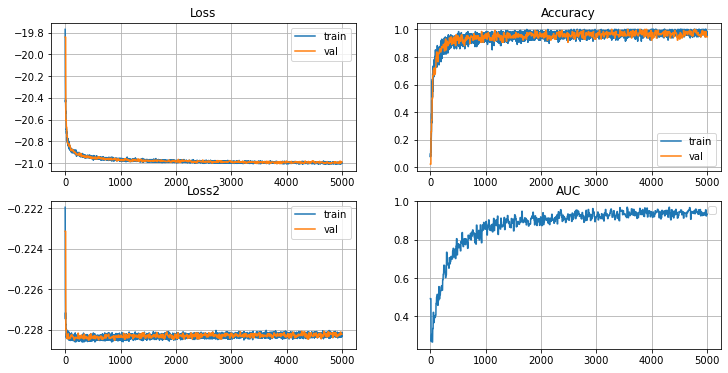

In [ ]:
results = {}
corruption_type_list = ['shot_noise', 'impulse_noise', 'rotate', 'canny_edges']
for corruption_type in corruption_type_list:
  (ds_train, ds_test), ds_info = tfds.load(
      'mnist_corrupted/identity',
      split=['train', 'test'],
      shuffle_files=True,
      as_supervised=True,
      with_info=True,
  )

  (_, ds_corrupted), ds_info = tfds.load(
      'mnist_corrupted/%s' % corruption_type,
      split=['train', 'test'],
      shuffle_files=True,
      as_supervised=True,
      with_info=True,
  )

  def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32) / 255.
    image = tf.reshape(image, (-1,))
    return image, label

  def make_ds(ds):
    ds = ds.map(
      normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache().repeat()
    ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

  ds_train = make_ds(ds_train)
  iter_train = iter(ds_train)

  ds_test = make_ds(ds_test)
  iter_test = iter(ds_test)

  ds_corrupted = make_ds(ds_corrupted)
  iter_corrupted = iter(ds_corrupted)

  for L in [0.0, 100.0]:
    print(corruption_type, L)
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

    @tf.function
    def loss_fn(X, Y):
      Y_hat = model(X)
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true=Y, y_pred=Y_hat)
      accuracy = tf.reduce_mean(tf.cast(tf.argmax(Y_hat, axis=1) == Y, tf.float32))

      ### Original version
      version = 'original'
      if version == 'original':
        with tf.GradientTape() as tape:
          tape.watch(X)
          Y_hat = model(X)
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true=Y, y_pred=Y_hat)
        grads = tape.gradient(loss, X)
        grads = -0.001 * grads / tf.norm(grads, axis=1)[:, None]
        X = tf.clip_by_value(X + grads, 0.0, 1.0)

        Y_hat = model(X)  
        loss2 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=tf.ones_like(Y_hat) / 10.0, y_pred=Y_hat)
        return loss + L * loss2, loss2, accuracy
      elif version == 'entropy':
        with tf.GradientTape() as tape:
          tape.watch(X)
          Y_hat = model(X)
          entropy = -1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1)
        grads = tape.gradient(entropy, X)
        grads = -0.001 * grads / tf.norm(grads, axis=1)[:, None]
        X = tf.clip_by_value(X + grads, 0.0, 1.0)

        Y_hat = model(X)
        entropy = -1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1)
        loss2 = -1.0 * tf.reduce_mean(entropy)
        return loss + L * loss2, loss2, accuracy, X
      else:
        raise ValueError

    @tf.function
    def step_fn(X_train, Y_train):
      with tf.GradientTape() as tape:
        loss, loss2, accuracy, X = loss_fn(X_train, Y_train)
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      return loss, loss2, accuracy, X

    @tf.function
    def eval_ood_helper(X_real, X_fake):
      Y_hat_real = model(X_real)
      entropy_real = -1.0 * tf.reduce_mean(Y_hat_real * tf.math.log(Y_hat_real), axis=1)
      Y_hat_fake = model(X_fake)
      entropy_fake = -1.0 * tf.reduce_mean(Y_hat_fake * tf.math.log(Y_hat_fake), axis=1)
      return tf.concat([entropy_real, entropy_fake], axis=0)

    def eval_ood(X_real, X_fake):
      logits = eval_ood_helper(X_real, X_fake).numpy()
      labels = np.concatenate([np.zeros(128), np.ones(128)])
      auc = roc_auc_score(labels, logits)
      return auc

    history = []
    for t in tqdm.trange(5000):
      X_train, Y_train = next(iter_train)
      train_loss, train_loss2, train_acc, X = step_fn(X_train, Y_train)
      if t % 10 == 0:
        X_test, Y_test = next(iter_test)
        test_loss, test_loss2, test_acc, _ = loss_fn(X_test, Y_test)
        X_corrupted, _ = next(iter_corrupted)
        test_auc = eval_ood(X_test, X_corrupted)
      history.append((train_loss.numpy(), test_loss.numpy(), train_acc.numpy(), test_acc.numpy(),
                      train_loss2.numpy(), test_loss2.numpy(), test_auc))
      if t % 100 == 0:
        print(test_auc)
    history = np.array(history)
    test_acc = np.mean(history[-500:, 3])
    test_auc = np.mean(history[-500:, 6])
    results[(corruption_type, L)] = (test_acc, test_auc)

    plt.figure(figsize=(12, 6))
    plt.subplot(221)
    plt.title('Loss')
    plt.plot(history[:, 0], label='train')
    plt.plot(history[:, 1], label='val')
    plt.grid()
    plt.legend()
    
    plt.subplot(222)
    plt.title('Accuracy')
    plt.plot(history[:, 2], label='train')
    plt.plot(history[:, 3], label='val')
    plt.grid()
    plt.legend()

    plt.subplot(223)
    plt.title('Loss2')
    plt.plot(history[:, 4], label='train')
    plt.plot(history[:, 5], label='val')
    plt.grid()
    plt.legend()

    plt.subplot(224)
    plt.title('AUC')
    plt.plot(history[:, 6])
    plt.grid()
    plt.legend()
    plt.show()

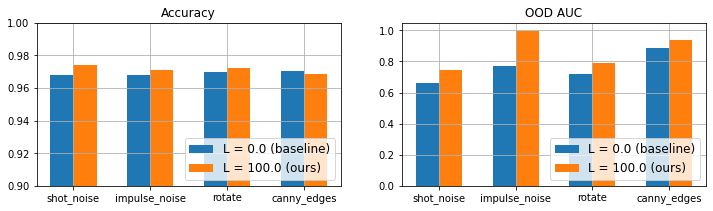

In [ ]:
plt.figure(figsize=(12, 3))
x = np.arange(len(corruption_type_list))
for (index, title) in enumerate(['Accuracy', 'OOD AUC']):
  plt.subplot(1, 2, index + 1)
  plt.title(title)
  for L in [0.0, 100.0]:
    y = []
    for corruption_type in corruption_type_list:
      y.append(results[(corruption_type, L)][index])
    plt.bar(x + 0.3 * (1 if L else 0) - 0.15, y, width=0.3, label='L = %s (%s)' % (L, 'ours' if L else 'baseline'))
  plt.xticks(x, corruption_type_list)
  plt.grid()
  plt.legend(fontsize=12, loc='lower right')
  if index == 0:
    plt.ylim([0.9, 1.0])
  # else:
  #   plt.ylim([0.6, 1.0])
plt.show()